In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# 0 - State Variables

$$ \mathit{\mathbf{x}}  = [x, y, z] $$

where z = 0 in 2D scene

# 1 - Process Model & Q 

In [2]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )

In [3]:
def f_contact(x, dt, u):
    A = np.identity(3)
    B = -dt * np.append(np.identity(3), skew(x), axis=1)    # -skew(p) ???
    prior_ = A @ x - B @ u # DYX: it should be plus, but here there's a coordinate translation needed to be done !!!
                            # -u is the velocity of base under fixed-world frame, if so, we should fix this and unify the frame
                            # u is actually the velocity of fixed contact point under whisker base frame
    return prior_

In [4]:
# Process Noise
Q = np.array([[.001, 0, 0], [0, .001, 0], [0, 0, .00001]])

# 2 - Measurement Model & R

In [5]:
def polyfit2d(x, y, z, kx=5, ky=5, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [6]:
import pandas as pd

dataframe_x = pd.read_excel("data/CalibrationData/1/FullRangeData_x.xlsx", sheet_name="1")
dataframe_y = pd.read_excel("data/CalibrationData/1/FullRangeData_y.xlsx", sheet_name="Formated_MannulyFixed")

zx = np.array(dataframe_x)[:, 2]
zy = np.array(dataframe_y)[:, 2]

print(zx)

x = np.linspace(5, 95, 19)
y = np.linspace(115, 160, 10)

coeff_x, r_x, rank_x, s_x = polyfit2d(np.linspace(50, 95, 10), y, zx, kx=3, ky=3)
coeff_y, r_y, rank_y, s_y = polyfit2d(x, y, zy)

[-10.70528322 -10.61579981 -10.59413312 -10.56163309 -10.52999973
 -10.49879971 -10.47063301 -10.44081965 -10.41100629 -10.38119294
 -10.69271654 -10.60366646 -10.56899977 -10.53303307 -10.48883303
 -10.43596632 -10.40346629 -10.3612307  -10.31996494 -10.27869919
 -10.69163321 -10.58979979 -10.54126641 -10.48016636 -10.43509965
 -10.38916628 -10.33153289 -10.31073287 -10.28256618 -10.22171375
 -10.69358321 -10.58979979 -10.52393306 -10.46629968 -10.4190663
 -10.34279957 -10.29599953 -10.26783284 -10.22319946 -10.18376609
 -10.70159988 -10.58416645 -10.51309972 -10.44766633 -10.3804996
 -10.29989953 -10.2660995  -10.20499945 -10.15603274 -10.08973268
 -10.70051655 -10.60626647 -10.52999973 -10.44246632 -10.34626624
 -10.25353282 -10.20109944 -10.13956606 -10.07803267 -10.00479929
 -10.71438323 -10.61276647 -10.53779974 -10.40346629 -10.31809955
 -10.19546611 -10.1170327   -9.98919929  -9.95149928  -9.91553264
 -10.75034993 -10.66519985 -10.5360664  -10.38266627 -10.19763277
 -10.0450993

In [7]:
from sklearn.metrics import r2_score

print("Fitted results on X-axis of magentic flux measurement: ")

fitted_surf_x = np.polynomial.polynomial.polygrid2d(np.linspace(50, 95, 10), y, coeff_x.reshape((4, 4)))

rms_x = np.sqrt(np.mean((zx.reshape(10, 10).T - fitted_surf_x) ** 2))
print("RMS residual =", rms_x)
score_x = r2_score(zx.reshape(10, 10).T, fitted_surf_x)
print("R-squared value =", score_x)

print("Fitted results on Y-axis of magentic flux measurement: ")

fitted_surf_y = np.polynomial.polynomial.polygrid2d(x, y, coeff_y.reshape((6, 6)))

rms_y = np.sqrt(np.mean((zy.reshape(10, 19).T - fitted_surf_y) ** 2))
print("RMS residual =", rms_y)
score_y = r2_score(zy.reshape(10, 19).T, fitted_surf_y)
print("R-squared value =", score_y)

Fitted results on X-axis of magentic flux measurement: 
RMS residual = 0.10970689534810164
R-squared value = 0.8741704121297742
Fitted results on Y-axis of magentic flux measurement: 
RMS residual = 0.25010603970216577
R-squared value = 0.9757431664999718


### Measurement Model Plot 2D & 3D

(19, 10)


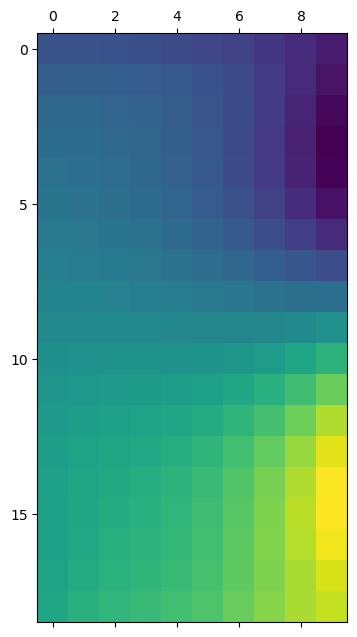

In [8]:
fitted_surf_y = np.polynomial.polynomial.polygrid2d(x, y, coeff_y.reshape((6, 6)))
print(fitted_surf_y.shape)
plt.matshow(fitted_surf_y)

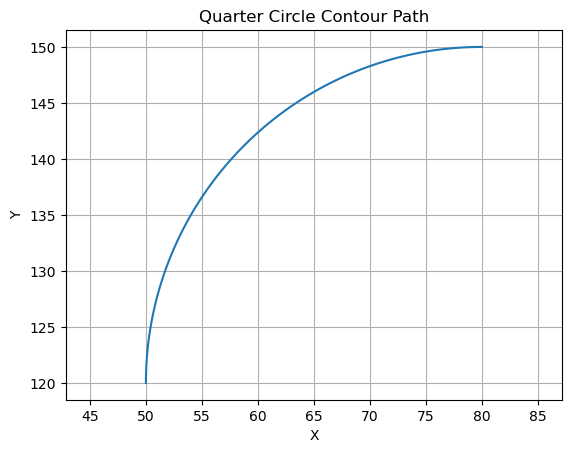

In [9]:
# Define start and end points
x_fic_start = 50
x_fic_end = 80
y_fic_start = 120
y_fic_end = 150

# Calculate center of the circle
center_x = x_fic_end
center_y = y_fic_start

# Calculate radius of the circle
radius = x_fic_end - x_fic_start

# Generate circle path
theta = np.linspace(np.pi, np.pi/2, 100)
circle_x = center_x + radius * np.cos(theta)
circle_y = center_y + radius * np.sin(theta)

# Plot circle
plt.plot(circle_x, circle_y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quarter Circle Contour Path')
plt.grid(True)
plt.axis('equal')
plt.show()

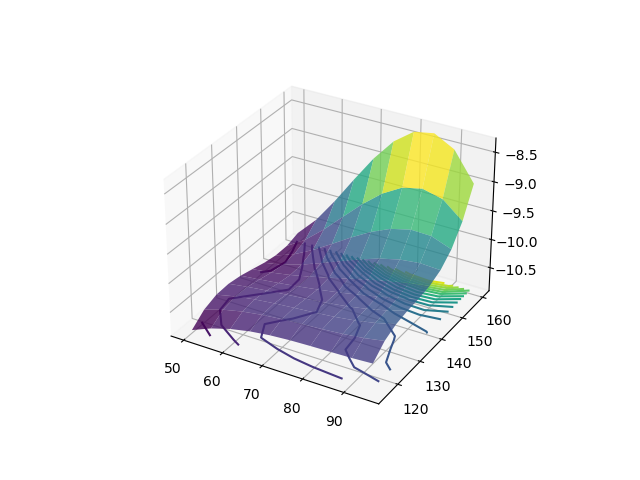

In [10]:
%matplotlib widget

X, Y = np.meshgrid(np.linspace(50, 95, 10), y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Plot surface
surf = ax.plot_surface(X, Y, fitted_surf_x.T, cmap="viridis", alpha=0.8)

# Plot contour lines on the surface
num_levels = 20
contour_levels = np.linspace(np.min(fitted_surf_x), np.max(fitted_surf_x), num_levels)
contour_surf = ax.contour(X, Y, fitted_surf_x.T, levels=contour_levels, offset=np.min(fitted_surf_x), cmap='viridis')

plt.show()

In [11]:
def h_contact(x):
    h_x = np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff_x.reshape((4, 4)))
    h_y = np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff_y.reshape((6, 6)))
    return np.array([h_x, h_y])

In [12]:
# Test : Single Point
x_1 = np.array([60, 140, 0])
x_2 = np.array([100, 140, 0])
print(h_contact(x_1), h_contact(x_2))

[-10.58792074   4.53412072] [-10.02180483   6.99535187]


In [13]:
# Measurement Noise
R = np.array([[rms_x**2, 0], [0, rms_y**2]])

# 3 -  Data Preprocess

In [14]:
# Data format : 
#           timestamp，
#           magnetic_x, magnetic_y, magnetic_z, 
#           lv_x, lv_y, lv_z, av_x, av_y. av_z

trajectory_df = pd.read_csv("data/D_Cir_6_1/trajectory.csv")

In [15]:
# delta time : second s

from datetime import datetime

dt_frame = np.array(trajectory_df)[:, 0]

dt = [0]
for i in range(1, dt_frame.shape[0]):
    tr = datetime.fromtimestamp(dt_frame[i])
    tf = datetime.fromtimestamp(dt_frame[i-1])
    dt.append((tr-tf).total_seconds())
dt = np.array(dt)

In [16]:
# linear- and angular-veolocity : mm/s & rad/s 

# be careful of coordinate frame translation !!!
linear_vel = np.array([np.array(trajectory_df)[:, 5], -np.array(trajectory_df)[:, 6], np.array(trajectory_df)[:, 4]]) * 1e3
angular_vel = np.array([np.array(trajectory_df)[:, 7], np.array(trajectory_df)[:, 8], np.array(trajectory_df)[:, 9]])

us = np.append(linear_vel, angular_vel, axis=0).T

In [17]:
# Measurements Update : magnetic_y
zs = [np.array([np.array(trajectory_df)[i, 1], np.array(trajectory_df)[i, 2]]) for i in range(trajectory_df.shape[0])]
zs[1]

array([-9.61999989,  6.36999989])

# 4 - UKF with Fading Memory

In [18]:
# Initial estimate

x_initial = np.array([50, 115, 0])

In [19]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

sigmas = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=0.)
ukf = UKF(dim_x=3, dim_z=2, fx=f_contact,
          hx=h_contact, dt=None, points=sigmas)

ukf.x = x_initial
ukf.R = R
ukf.Q = Q

# Introduce adaptive fading memory filter to compensate the error from dynamic contact 
ukf.alpha = 1.008

In [20]:
ukf

UnscentedKalmanFilter object
x = [ 50 115   0]
P = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
x_prior = [0. 0. 0.]
P_prior = [[1. 0. 0.]
           [0. 1. 0.]
           [0. 0. 1.]]
Q = [[1.e-03 0.e+00 0.e+00]
     [0.e+00 1.e-03 0.e+00]
     [0.e+00 0.e+00 1.e-05]]
R = [[0.0120356  0.        ]
     [0.         0.06255303]]
S = [[0. 0.]
     [0. 0.]]
K = [[0. 0.]
     [0. 0.]
     [0. 0.]]
y = [0. 0.]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
sigmas_f = [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]
h = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]
Wm = [-99.          16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
Wc = [-96.01        16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
residual_x = <ufunc 'subtract'>
residual

# 5 - Test

In [21]:
uxs = []
for _ in range(len(zs)):
    ukf.predict(u=us[_], dt=dt[_])
    ukf.update(zs[_])
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

[[-10.86103454   3.38977673]
 [-10.85549157   3.40049785]
 [-10.85322603   3.39111424]
 [-10.86103454   3.38977673]
 [-10.86663252   3.3790487 ]
 [-10.86898056   3.38836764]
 [-10.86103454   3.38977673]]
[[-10.60497322   3.74598398]
 [-10.60224586   3.7566544 ]
 [-10.60134992   3.74749852]
 [-10.60497322   3.74598398]
 [-10.60773125   3.73527597]
 [-10.6086981    3.74442161]
 [-10.60497322   3.74598398]]
[[-10.51584291   4.02452759]
 [-10.51408967   4.03431866]
 [-10.51374152   4.02702075]
 [-10.51584291   4.02452759]
 [-10.51761729   4.01467893]
 [-10.51803242   4.02199626]
 [-10.51584291   4.02452759]]
[[-10.4745059    4.2106054 ]
 [-10.47319338   4.21957976]
 [-10.47326523   4.2138033 ]
 [-10.4745059    4.2106054 ]
 [-10.47583425   4.20156316]
 [-10.47582454   4.20737645]
 [-10.4745059    4.2106054 ]]
[[-10.4483921    4.37456266]
 [-10.44735207   4.38252003]
 [-10.44765882   4.37851294]
 [-10.4483921    4.37456266]
 [-10.44944435   4.36653019]
 [-10.44919564   4.3705855 ]
 [-10.4483

In [22]:
uxs.shape

(1129, 3)

[[ 5.50405157e+01  1.18768669e+02  1.52931573e-16]
 [ 5.83755952e+01  1.20176551e+02  5.12701033e-16]
 [ 6.16684138e+01  1.21204480e+02  4.14914726e-16]
 ...
 [ 9.24795174e+01  1.31257573e+02 -2.71684044e-13]
 [ 9.17994698e+01  1.31510554e+02 -2.92770524e-13]
 [ 9.18226068e+01  1.31646986e+02 -3.06582174e-13]]


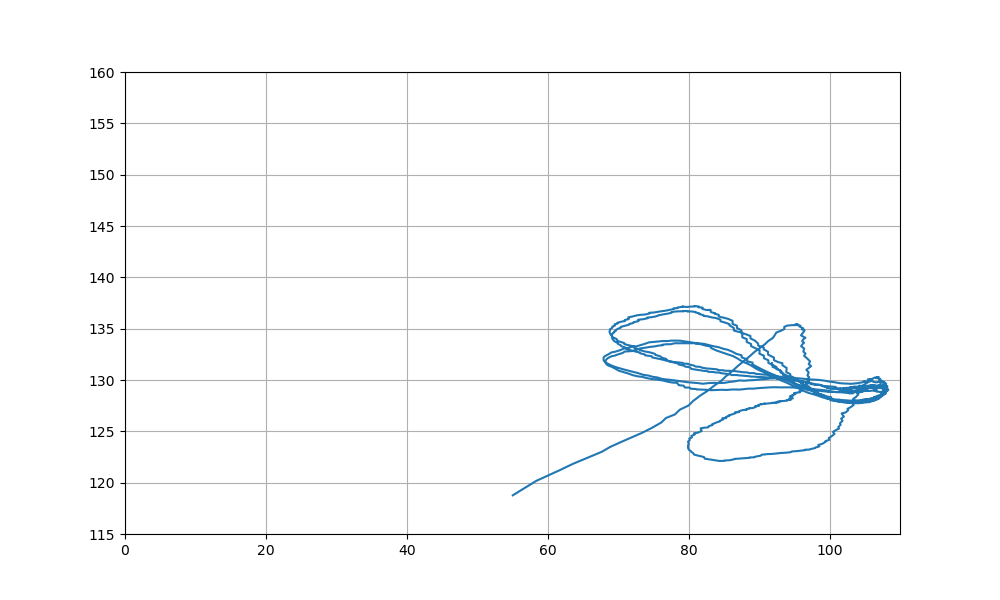

In [23]:
print(uxs)

plt.figure(figsize=(10, 6))
plt.grid()
plt.ylim([115, 160])
plt.xlim([0, 110])
plt.plot(uxs[:, 0], uxs[:, 1], label='Estimated Trajectory')

### Dynamic contact results:

In [24]:
# set the first base frame position as the origin of fixed world frame

uxs_ = []
displacement = np.array([0. ,0. ,0.]) # overall position displacement from first iteration

for _ in range(uxs.shape[0]):
    displacement += np.dot(us[_][:3], dt[_])
    temp = uxs[_] + displacement
    uxs_.append(temp)
uxs_ = np.array(uxs_)

In [25]:
uxs_.shape

(1129, 3)

[[ 5.50405157e+01  1.18768669e+02  1.52931573e-16]
 [ 5.83783016e+01  1.20176551e+02  5.12701033e-16]
 [ 6.23136794e+01  1.21204480e+02  4.14914726e-16]
 ...
 [ 8.65131920e+01  1.31257573e+02 -2.71684044e-13]
 [ 8.51704980e+01  1.31510554e+02 -2.92770524e-13]
 [ 8.51922885e+01  1.31646986e+02 -3.06582174e-13]]


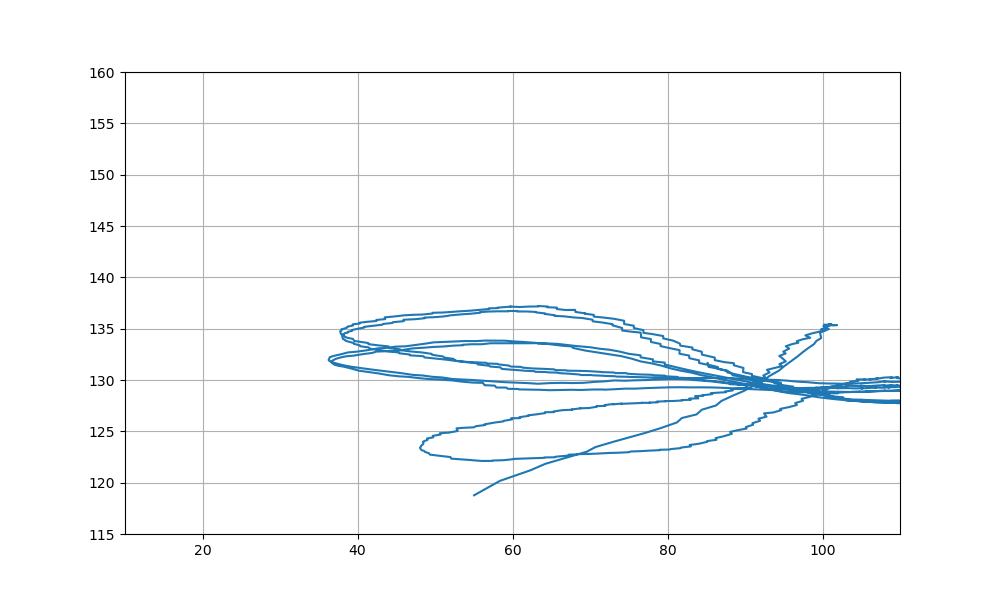

In [26]:
print(uxs_)

plt.figure(figsize=(10, 6))
plt.grid()
plt.ylim([115, 160])
plt.xlim([10, 110])
plt.plot(uxs_[:, 0], uxs_[:, 1], label='Estimated Trajectory')

We shall check how the magnetic flux changed in the certain direction: y 

In [27]:
t = np.array(trajectory_df)[:, 0]
mag_x = np.array(trajectory_df)[:, 1]
mag_y = np.array(trajectory_df)[:, 2]
mag_z = np.array(trajectory_df)[:, 3]

print(np.min(mag_y), np.max(mag_y))

4.679999828338623 6.889999866485596


[1.70902438e+09 1.70902438e+09 1.70902438e+09 ... 1.70902441e+09
 1.70902441e+09 1.70902441e+09]
[6.36999989 6.36999989 6.5        ... 6.10999966 6.23999977 5.97999954]


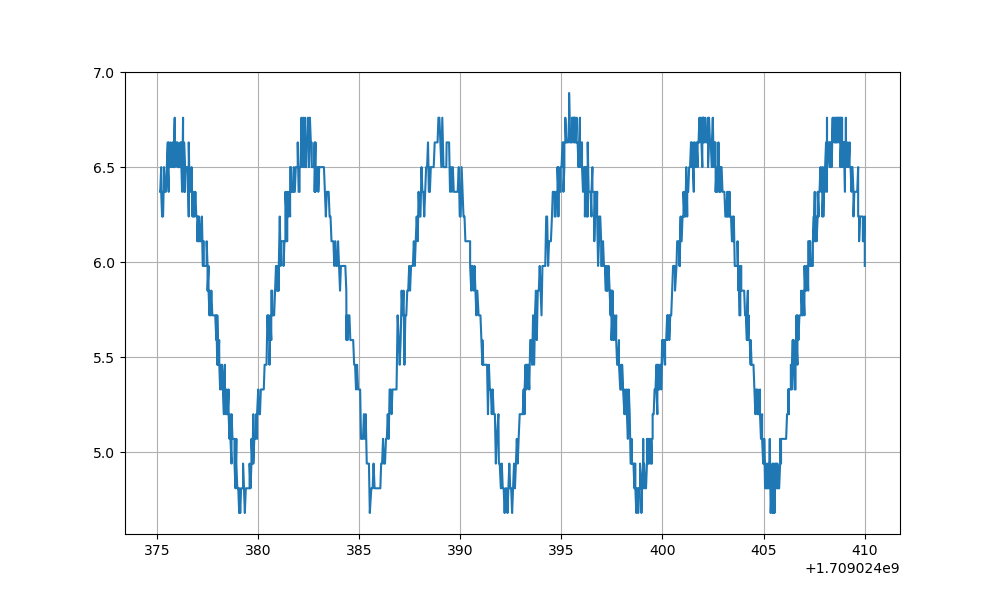

In [28]:
print(t)
print(mag_y)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(t[:], mag_y[:], label='Magnetic Flux in Y-axis')

[1.70902438e+09 1.70902438e+09 1.70902438e+09 ... 1.70902441e+09
 1.70902441e+09 1.70902441e+09]
[ -9.61999989  -9.61999989  -9.48999977 ...  -9.61999989 -10.00999928
  -9.75      ]


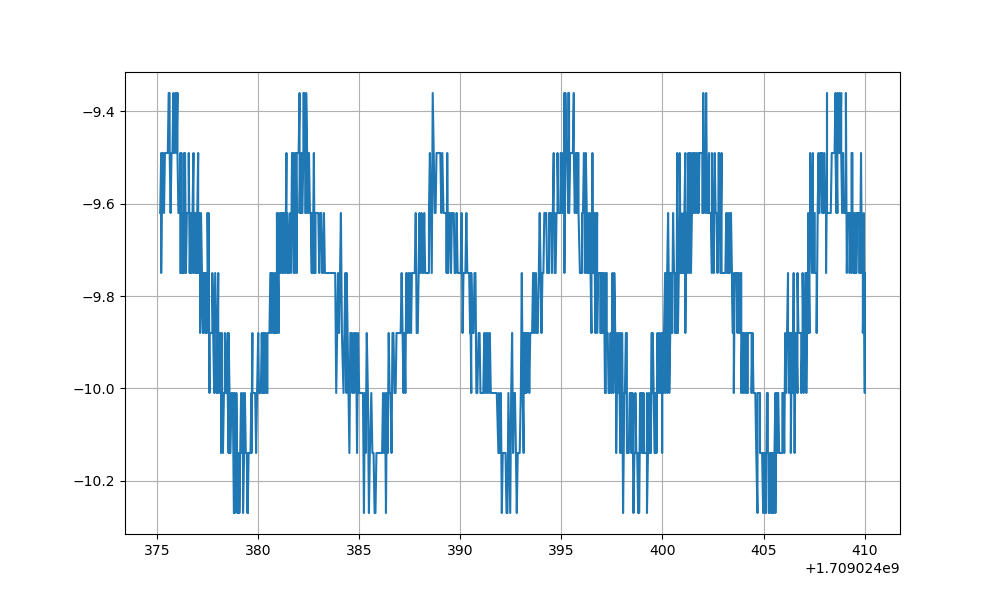

In [29]:
print(t)
print(mag_x)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(t[:], mag_x[:], label='Magnetic Flux in Y-axis')

[ -9.61999989  -9.61999989  -9.48999977 ...  -9.61999989 -10.00999928
  -9.75      ]
[6.36999989 6.36999989 6.5        ... 6.10999966 6.23999977 5.97999954]


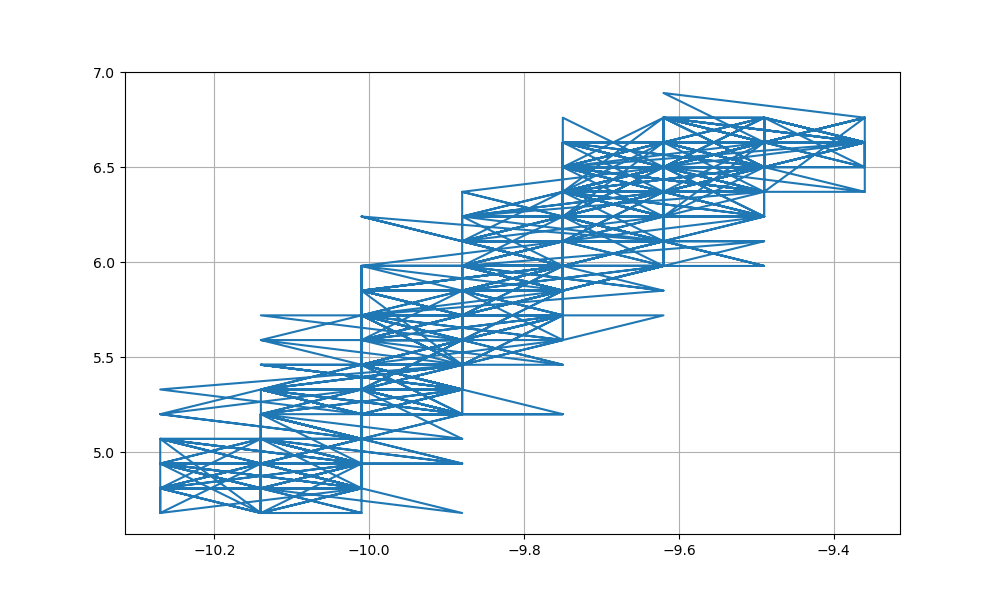

In [30]:
print(mag_x)
print(mag_y)

plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(mag_x[:], mag_y[:], label='Magnetic Flux in Y-axis')